In [99]:
from enum import Enum

In [100]:
class AnalysisSteps(Enum):
    """
    An enumerate of the steps executed by the :class:`~BaseAnalysis` (and the default
    for subclasses).

    The involved steps are specified below.

    .. jupyter-execute::
        :hide-code:

        from quantify.analysis import base_analysis as ba
        print(ba.analysis_steps_to_str(ba.AnalysisSteps))

    .. include:: ./docstring_examples/quantify.analysis.base_analysis.AnalysisSteps.rst.txt

    .. tip::

        A custom analysis flow (e.g. inserting new steps) can be created by implementing
        an object similar to this one and overloading the
        :obj:`~BaseAnalysis.analysis_steps`.
    """  # pylint: disable=line-too-long

    # Variables must start with a letter but we want them to have sorted names
    # for auto-complete to indicate the execution order
    STEP_0_EXTRACT_DATA = "extract_data"
    STEP_1_PROCESS_DATA = "process_data"
    STEP_2_RUN_FITTING = "run_fitting"
    STEP_3_ANALYZE_FIT_RESULTS = "analyze_fit_results"
    STEP_4_CREATE_FIGURES = "create_figures"
    STEP_5_ADJUST_FIGURES = "adjust_figures"
    STEP_6_SAVE_FIGURES = "save_figures"
    STEP_7_SAVE_QUANTITIES_OF_INTEREST = "save_quantities_of_interest"
    STEP_8_SAVE_PROCESSED_DATASET = "save_processed_dataset"

In [103]:
AnalysisSteps.

<AnalysisSteps.STEP_0_EXTRACT_DATA: 'extract_data'>

In [1]:
import numpy as np 


In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from qcodes import ManualParameter, Parameter
# %matplotlib inline

In [3]:
from quantify.measurement import MeasurementControl
from quantify.measurement.control import Settable, Gettable
import quantify.visualization.pyqt_plotmon as pqm
from quantify.visualization.instrument_monitor import InstrumentMonitor

In [4]:
# This sets a default data directory for tutorial purposes. Change it to your desired data directory.
from pathlib import Path
from os.path import join
from quantify.data.handling import get_datadir, set_datadir
set_datadir(join(Path.home(), 'quantify-data')) # change me!
print(f"Data will be saved in:\n{get_datadir()}")

Data will be saved in:
/Users/adriaanrol/quantify-data


In [5]:
from quantify.data.handling import initialize_dataset

In [8]:
MC = MeasurementControl("MC")

In [9]:

from time import sleep

# We create an instrument to contain all the parameters of our model to ensure we have proper data logging.
from qcodes.instrument import Instrument

pars = Instrument('ParameterHolder')

# ManualParameter's is a handy class that preserves the QCoDeS' Parameter
# structure without necessarily having a connection to the physical world
pars.add_parameter('amp', initial_value=1, unit='V', label='Amplitude', parameter_class=ManualParameter)
pars.add_parameter('freq', initial_value=.5, unit='Hz', label='Frequency', parameter_class=ManualParameter)
pars.add_parameter('t', initial_value=1, unit='s', label='Time', parameter_class=ManualParameter)
pars.add_parameter('phi', initial_value=0, unit='Rad', label='Phase', parameter_class=ManualParameter)
pars.add_parameter('noise_level', initial_value=0.05, unit='V', label='Noise level', parameter_class=ManualParameter)
pars.add_parameter('acq_delay', initial_value=.1, unit='s', parameter_class=ManualParameter)

def cos_func(t, amplitude, frequency, phase, offset):
    """A simple cosine function"""
    return amplitude * np.cos(2 * np.pi * frequency * t + phase) + offset

def cosine_model():
    sleep(pars.acq_delay()) # simulates the acquisition delay of an instrument
    return cos_func(pars.t(), pars.amp(), pars.freq(), phase=pars.phi(), offset=0) + np.random.randn() * pars.noise_level()

# We wrap our function in a Parameter to be able to associate metadata to it, e.g. units
sig = pars.add_parameter(name='sig', label='Signal level', unit='V', get_cmd=cosine_model)

KeyError: 'Another instrument has the name: ParameterHolder'

In [10]:
MC.settables(pars.t)                     # as a QCoDeS parameter, 't' obeys the JSON schema for a valid Settable and can be passed to the MC directly.
MC.setpoints(np.linspace(0, 5, 50))
MC.gettables(pars.sig)                   # as a QCoDeS parameter, 'sig' obeys the JSON schema for a valid Gettable and can be passed to the MC directly.
dset = MC.run('Cosine test')

Starting iterative measurement...
100% completed  elapsed time:      5s  time left:      0s  
100% completed  elapsed time:      5s  time left:      0s  

In [11]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Coordinates:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.9763 0.9477 0.8114 ... -0.8424 -0.9629 -1.019
Attributes:
    tuid:     20210417-183949-928-dce46d
    name:     Cosine test
    2D-grid:  False

In [14]:
import xarray as xr
x0 =np.linspace(0, 2*np.pi, 31)
y0 = np.cos(x0)


In [53]:
x0r = xr.DataArray(x0,  name="x0", attrs={"name": "t",'long_name': "Time", "units":"s"})
y0r= xr.DataArray(y0,  name="y0", attrs={"name":"A", 'long_name': "Amplitude", "units":"V"})

In [56]:
from quantify.data.handling import gen_tuid

In [57]:
gen_tuid()

'20210417-191934-749-41de74'

In [72]:
dset = xr.Dataset({"x0":x0r, "y0":y0r}, attrs={"name": "custom cosine", "tuid":gen_tuid()})
dset = dset.set_coords(["x0"])
dset 

<xarray.Dataset>
Dimensions:  (dim_0: 31)
Coordinates:
    x0       (dim_0) float64 0.0 0.2094 0.4189 0.6283 ... 5.864 6.074 6.283
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 1.0 0.9781 0.9135 0.809 ... 0.809 0.9135 0.9781 1.0
Attributes:
    name:     custom cosine
    tuid:     20210417-194251-466-92b722

In [75]:
from quantify.analysis import base_analysis as ba
from importlib import reload
reload(ba)

<module 'quantify.analysis.base_analysis' from '/Users/adriaanrol/GitHubRepos/Professional/quantify-core/quantify/analysis/base_analysis.py'>

In [67]:
tuid = dset.attrs['tuid']

In [66]:
from quantify.data.types import TUID

In [82]:
reload(ba)
a=ba.Basic1DAnalysis(dataset_raw=dset)

In [83]:
a.dataset

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [84]:
a.dataset_raw

<xarray.Dataset>
Dimensions:  (dim_0: 31)
Coordinates:
    x0       (dim_0) float64 0.0 0.2094 0.4189 0.6283 ... 5.864 6.074 6.283
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 1.0 0.9781 0.9135 0.809 ... 0.809 0.9135 0.9781 1.0
Attributes:
    name:     custom cosine
    tuid:     20210417-194251-466-92b722

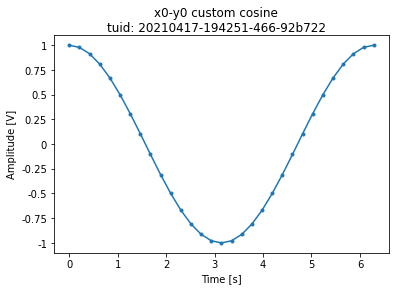

In [86]:
a.figs_mpl['Line plot x0-y0']

In [98]:
from quantify.data import handling as dh 
from quantify.data.handling import locate_experiment_container
exp_dir = locate_experiment_container(a.tuid, dh.get_datadir())
assert "analysis_Basic1DAnalysis" in os.listdir(exp_dir)
analysis_dir = os.listdir(Path(exp_dir) / "analysis_Basic1DAnalysis")
assert "figs_mpl" in analysis_dir


['Line plot x0-y0.svg', 'Line plot x0-y0.png']

In [80]:
dset.name

'custom cosine'

In [79]:
try: 
    ba.locate_experiment_container(tuid)
except FileNotFoundError:
    print('hi')

['20210417-182246-430-e1e285-my experiment', '20210417-182335-359-68cac2-2D radial setpoints', '20210417-182236-986-0c0e9b-demo', '20210417-182351-690-339a66', '20210417-182448-769-b00145-my experiment', '20210417-182246-638-ef5dbf-my experiment', '20210417-182438-293-c2f383-ADC scan', '20210417-182506-217-4c8ff0-2D-single-float-valued-settable-gettable', '20210417-182506-606-df7347-demo', '20210417-182327-371-002712-Cosine test', '20210417-182236-698-f30b56-demo', '20210417-182237-269-4715b0-demo', '20210417-182312-955-317d77-2D-single-float-valued-settable-gettable', '20210417-182246-912-51e197-my experiment', '20210417-182352-834-2b4979-averaged', '20210417-182327-827-290387-Many points live plot test', '20210417-182409-937-eb178e-nelder_mead_optimization', '20210417-182329-238-c74b9b-2D Cosine test', '20210417-182236-340-4ccd36-2D-single-float-valued-settable-gettable', '20210417-182313-360-3ba61c-demo', '20210417-182447-404-607ce5-Frequency sweep', '20210417-182451-140-7e362a-my e

In [ ]:
)

In [37]:
dset.set_coords?

Signature: dset.set_coords(names: 'Union[Hashable, Iterable[Hashable]]') -> 'Dataset'
Docstring:
Given names of one or more variables, set them as coordinates

Parameters
----------
names : hashable or iterable of hashable
    Name(s) of variables in this dataset to convert into coordinates.

Returns
-------
Dataset

See Also
--------
Dataset.swap_dims
File:      /usr/local/lib/python3.8/site-packages/xarray/core/dataset.py
Type:      method


In [ ]:
xarray

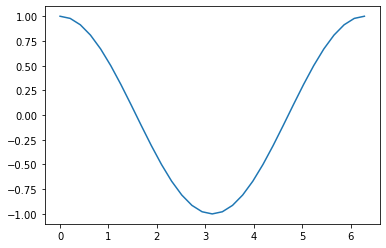

In [15]:
plt.plot(x0, y0)

In [ ]:
from quantify.measurement.control import MeasurementControl 
from qcodes.instrument.parameter import ManualParameter

In [3]:
times

array([5])

In [4]:
from typing import Union

In [6]:

Union?

Signature:   Union(*args, **kwds)
Type:        _SpecialForm
String form: typing.Union
File:        /usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib/python3.8/typing.py
Docstring:  
Internal indicator of special typing constructs.
See _doc instance attribute for specific docs.


In [7]:
abs_times = [0, 200e-6, 200e-6 + 20e-9]

In [9]:
abs_times*5

[0,
 0.0002,
 0.00020002,
 0,
 0.0002,
 0.00020002,
 0,
 0.0002,
 0.00020002,
 0,
 0.0002,
 0.00020002,
 0,
 0.0002,
 0.00020002]

In [10]:
from pathlib import Path
import json
import tempfile
import pytest
import numpy as np
import quantify.scheduler.schemas.examples as es
from quantify.scheduler.schedules import timedomain_schedules as ts
from quantify.scheduler.compilation import determine_absolute_timing, qcompile
from quantify.data.handling import set_datadir

# FIXME to be replaced with fixture in tests/fixtures/schedule from !49 # pylint: disable=fixme
tmp_dir = tempfile.TemporaryDirectory()

path = Path(es.__file__).parent.joinpath("transmon_test_config.json")
DEVICE_CFG = json.loads(path.read_text())

path = Path(es.__file__).parent.joinpath("qblox_test_mapping.json")
HARDWARE_MAPPING = json.loads(path.read_text())


In [17]:
set_datadir(tmp_dir.name)
sched_kwargs = {
    "pulse_amplitude": 0.5,
    "pulse_duration": 20e-9,
    "frequency": 5.442e9,
    "qubit": "q0",
    "port": None,
    "clock": None,
}

sched = ts.rabi_sched(**sched_kwargs)
sched = qcompile(sched, DEVICE_CFG)



{'label': 'Rabi_pulse',
 'rel_time': 0,
 'ref_op': None,
 'ref_pt_new': 'start',
 'ref_pt': 'end',
 'operation_hash': 2953932198996904262,
 'abs_time': 0.0002}

In [26]:

h1 = sched.timing_constraints[1]['operation_hash']
sched.operations[h1]['pulse_info'][0]

{'wf_func': 'quantify.scheduler.waveforms.drag',
 'G_amp': 0.5,
 'D_amp': 0,
 'duration': 2e-08,
 'phase': 0,
 'nr_sigma': 4,
 'clock': 'q0.01',
 'port': 'q0:mw',
 't0': 0}

In [32]:
sched.resources['q0.01']['freq']

5442000000.0

In [34]:
amps=np.linspace(-.5, .5, 5)
sched = ts.rabi_sched(
    pulse_amplitude= amps,
    pulse_duration= 20e-9,
    frequency= 5.442e9,
    qubit= "q0",
    port= None,
    clock= None)

In [37]:

h1 = sched.timing_constraints[1]['operation_hash']
sched.operations[h1]['pulse_info'][0]

{'wf_func': 'quantify.scheduler.waveforms.drag',
 'G_amp': array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ]),
 'D_amp': 0,
 'duration': 2e-08,
 'phase': 0,
 'nr_sigma': 4,
 'clock': 'q0.01',
 'port': 'q0:mw',
 't0': 0}

In [39]:
amps = np.arange(5)
durations = .4

In [42]:
durations = np.asarray(durations)
durations = durations.reshape(durations.shape or (1,))

    

In [43]:
durations

array([0.4])

In [44]:
len(durations)

1

In [45]:
len(amps)

5

In [48]:

np.ones(np.shape(amps))*durations

array([0.4, 0.4, 0.4, 0.4, 0.4])

In [49]:
import itertools

In [51]:

c = itertools.repeat(5)

##### 